# 9-11 프로젝트 네이버 영화리뷰 감성분석


## data download

In [ ]:
'''
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

'''

In [5]:
#!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2020-09-02 14:20:13--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.108.133
접속 raw.githubusercontent.com (raw.githubusercontent.com)|151.101.108.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  6.85MB/s    in 2.0s    

2020-09-02 14:20:16 (6.85 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]



In [6]:
#!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2020-09-02 14:20:27--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
접속 raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  5.45MB/s    in 0.9s    

2020-09-02 14:20:29 (5.45 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]



## library import

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

## data import 

In [15]:
# 데이터를 읽어봅시다. 
# train_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E09-rnn_txt_sentimental_analysis/data/ratings_train.txt'
# test_path = os.getenv('HOME') +'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E09-rnn_txt_sentimental_analysis/data/ratings_test.txt'
train_path = './data/ratings_train.txt'
test_path = './data/ratings_test.txt'

train_data = pd.read_table(train_path)
test_data = pd.read_table(test_path)

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## data loader

- imdb.dataloader() 메소드
- 숫자 인덱스, word to index 딕셔너리 제공.
<br/><br/>
- nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일 
<br/><br/>
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### data 전처리 / train test data 

In [41]:
from konlpy.tag import Mecab
tokenizer = Mecab() # 한국어 토큰 나이저 정의

# 불용어.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data): # num_words=num_words
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측치 제거 dropna 
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    #print("train_data \n", train_data)
    
    #한국어 토크나이저로 토큰화. , 불용어 제거
    ## train data
    X_train = []
    for sentence in train_data['document']:
        
        tokensized_x = tokenizer.morphs(sentence) #  토큰화
        tokensized_x = [word for word in tokensized_x if not word in stopwords]# 불용어 숙청
        X_train.append(tokensized_x)
    ## test data
    X_test = []
    for sentence in test_data['document']:
        tokensized_x = tokenizer.morphs(sentence) #  토큰화
        tokensized_x = [word for word in tokensized_x if not word in stopwords]# 불용어 숙청
        X_test.append(tokensized_x)
        
    print("X_train \n", X_train)
        
    # np. concatenate 배열 합치는 함수.
    # np . tolist list로
    words = np.concatenate(X_train).tolist()
    
    # Counter('hello world') 
    # Counter({'l': 3, 'o': 2, 'h': 1, 'e': 1, ' ': 1, 'w': 1, 'r': 1, 'd': 1})
    counter = Counter(words)
    print("\ncounter: ", counter)
    
    # most_common : 데이터 개수 가 많은 순으로 정렬된 배열 딕셔너리 리턴.
    # 매개변수 리턴 받을 배열 크기 지정 10000-4  10000개 데이터 딕셔너리 -4는 아마 밑에  4개
    counter = counter.most_common(10000-4)  
    # <PAD> # 패딩용 단어
    # <BOS>  # 문장의 시작지점
    # <UNK>  # 사전에 없는(Unknown) 단어
    # <UNUSED> # ?
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    
    # word를 index로 ....
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 함수정의: 문자리스트를 인덱스리스토로..
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    
    # return 
    # Xtrain / ytrain(라벨 분리) / X_test / y_test(라벨분리) / word_to_index
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




counter:  Counter({'.': 159415, '영화': 57338, '다': 54971, '고': 47196, '하': 44376, '을': 29832, '보': 25603, '..': 22655, '게': 22161, ',': 22047, '!': 19269, '지': 19138, '있': 16685, '없': 15801, '?': 15323, '좋': 13668, '나': 12601, '었': 12175, '만': 11669, '는데': 11515, '너무': 10974, '봤': 10235, '적': 10106, '안': 10076, '정말': 9751, '로': 9645, '음': 9340, '것': 9269, '아': 9098, '네요': 9004, '재밌': 8758, '어': 8742, '같': 8574, '점': 8566, '지만': 8361, '진짜': 8300, '했': 8156, '에서': 8071, '기': 8055, '네': 7813, '않': 7726, '거': 7681, '았': 7614, '수': 7509, '되': 7469, '면': 7273, 'ㅋㅋ': 7197, '말': 6891, '연기': 6833, '인': 6773, '주': 6573, '내': 6319, '최고': 6317, '~': 6299, '평점': 6248, '이런': 5994, '던': 5902, '어요': 5760, '할': 5534, '왜': 5520, '겠': 5477, '1': 5442, '스토리': 5419, '해': 5415, '습니다': 5345, 'ㅋㅋㅋ': 5314, '...': 5306, '드라마': 5173, '생각': 5166, '아니': 5156, '더': 5146, '그': 5089, '싶': 5046, '사람': 5034, '듯': 4990, '때': 4828, '감동': 4823, '함': 4668, '배우': 4641, '본': 4563, '까지': 4504, '뭐': 4309, '알': 4255, '만들': 4255

In [42]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [43]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 문장길이 분포

In [44]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))



문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 적절한 최대 문장 길이 지정


In [45]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)) )

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 추가
- keras.preprocessing.sequence.pad_sequences 을 활용

In [46]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성

### 모델 정의 (모델1)

In [48]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
#########################################
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
#########################################
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 검증셋 분리

In [135]:
# validation set 10000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)

print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 41)
(40000,)
(106182, 41)
(106182,)


## 모델 훈련개시

In [136]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, #512
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 1s 3ms/step - loss: 0.1076 - accuracy: 0.9646 - val_loss: 0.8101 - val_accuracy: 0.8127
Epoch 2/20
208/208 [==============================] - 1s 3ms/step - loss: 0.1042 - accuracy: 0.9660 - val_loss: 0.8164 - val_accuracy: 0.8114
Epoch 3/20
208/208 [==============================] - 1s 3ms/step - loss: 0.1018 - accuracy: 0.9671 - val_loss: 0.8260 - val_accuracy: 0.8104
Epoch 4/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0998 - accuracy: 0.9679 - val_loss: 0.8453 - val_accuracy: 0.8101
Epoch 5/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.9686 - val_loss: 0.8433 - val_accuracy: 0.8099
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0965 - accuracy: 0.9692 - val_loss: 0.8605 - val_accuracy: 0.8094
Epoch 7/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9702 - val_loss: 0.8753 - val_accuracy: 0.8093
Epoch 

## 평가

In [137]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 1.0312 - accuracy: 0.8016
[1.0311740636825562, 0.8016355633735657]


## loss accuracy 그래프 시긱화

In [138]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들ㅊ

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


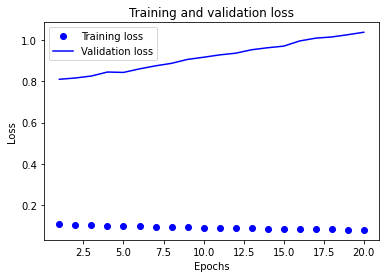

In [139]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

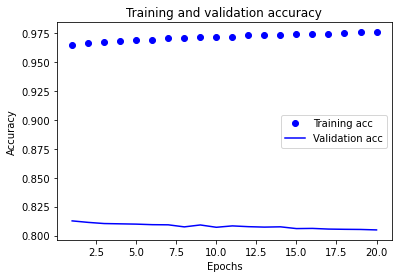

In [140]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 embedding 레이어 분석

## 다른모델 (모델2) _ LSTM

### DATA SET

In [142]:
# validation set 10000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)

print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 41)
(40000,)
(106182, 41)
(106182,)


### 모델 정의

In [150]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### 훈련

In [212]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, #512
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
247/247 [==============================] - 6s 26ms/step - loss: 0.0509 - accuracy: 0.9833 - val_loss: 0.6348 - val_accuracy: 0.8564
Epoch 2/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0464 - accuracy: 0.9844 - val_loss: 0.6771 - val_accuracy: 0.8516
Epoch 3/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0426 - accuracy: 0.9856 - val_loss: 0.6575 - val_accuracy: 0.8554
Epoch 4/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.7310 - val_accuracy: 0.8541
Epoch 5/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0364 - accuracy: 0.9875 - val_loss: 0.7003 - val_accuracy: 0.8532
Epoch 6/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0343 - accuracy: 0.9883 - val_loss: 0.7073 - val_accuracy: 0.8527
Epoch 7/15
247/247 [==============================] - 6s 25ms/step - loss: 0.0338 - accuracy: 0.9883 - val_loss: 0.7323 - val_accuracy: 0.8539

### 평가

In [145]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.4750 - accuracy: 0.8257
[0.4750464856624603, 0.8257012963294983]


In [146]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들ㅊ

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


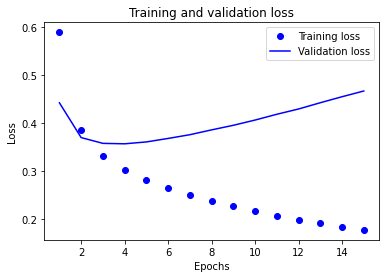

In [147]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

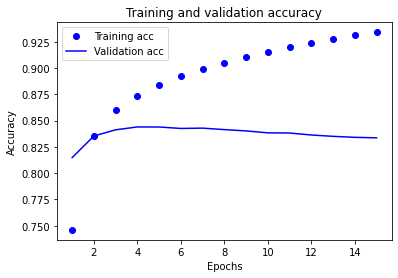

In [148]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 다른모델(모델3) _ LSTM

### data set

In [156]:
# validation set 10000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)

print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 41)
(40000,)
(106182, 41)
(106182,)


### 모델 정의

In [157]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### 훈련

In [158]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, #512
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 4s 19ms/step - loss: 0.4865 - accuracy: 0.7354 - val_loss: 0.3583 - val_accuracy: 0.8419
Epoch 2/15
208/208 [==============================] - 4s 18ms/step - loss: 0.3379 - accuracy: 0.8557 - val_loss: 0.3478 - val_accuracy: 0.8487
Epoch 3/15
208/208 [==============================] - 4s 18ms/step - loss: 0.3028 - accuracy: 0.8708 - val_loss: 0.3403 - val_accuracy: 0.8510
Epoch 4/15
208/208 [==============================] - 4s 18ms/step - loss: 0.2737 - accuracy: 0.8841 - val_loss: 0.3383 - val_accuracy: 0.8559
Epoch 5/15
208/208 [==============================] - 4s 18ms/step - loss: 0.2456 - accuracy: 0.8971 - val_loss: 0.3473 - val_accuracy: 0.8547
Epoch 6/15
208/208 [==============================] - 4s 18ms/step - loss: 0.2235 - accuracy: 0.9086 - val_loss: 0.3688 - val_accuracy: 0.8540
Epoch 7/15
208/208 [==============================] - 4s 18ms/step - loss: 0.2026 - accuracy: 0.9182 - val_loss: 0.4042 - val_accuracy: 0.8539

### 평가

In [159]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6117 - accuracy: 0.8357
[0.6117311120033264, 0.8357304334640503]


In [160]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들ㅊ

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


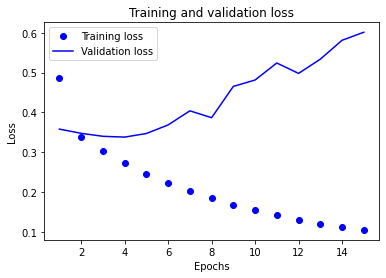

In [161]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

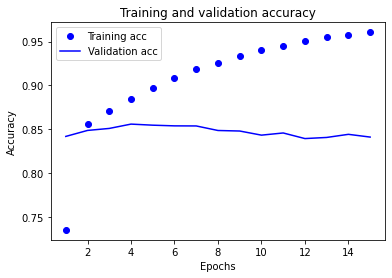

In [162]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 한국어 Word2Vec 임베딩 활용하여 성능개선
- https://github.com/Kyubyong/wordvectors

### embedding layer 분석

In [170]:
from gensim.models import KeyedVectors

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [171]:

#word2vec_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E09-rnn_txt_sentimental_analysis/data/GoogleNews-vectors-negative300.bin.gz'
word2vec_file_path = './data/lstmword2vce.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [174]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['스토리']
vector

array([ 0.06021687, -0.02835768,  0.04066293,  0.01843846, -0.03839768,
        0.06503545, -0.06645738,  0.07192626, -0.03667098,  0.02327793,
       -0.0818037 , -0.04494195,  0.04998245,  0.04096612, -0.00693375,
       -0.03954151,  0.01337427,  0.07181793, -0.01943722,  0.05105037,
       -0.01650462,  0.0357435 , -0.04195341, -0.04671171,  0.05463983,
       -0.03680097, -0.0603186 , -0.02257641,  0.03025941,  0.06997365,
        0.00421533, -0.04613915,  0.08427899, -0.09972654,  0.05777612,
        0.02710667, -0.053709  ,  0.00122915, -0.0177668 ,  0.02886664,
        0.06470221,  0.04288834, -0.00448622, -0.05613456, -0.02416762,
       -0.04470058, -0.03532831, -0.0108598 ,  0.0686768 , -0.05120867,
       -0.00702417, -0.02807229,  0.0716195 ,  0.05294037,  0.06364435,
       -0.03050881, -0.04861434, -0.01431306,  0.01585589,  0.06334991,
        0.02441968, -0.04887265,  0.04752753, -0.07422847,  0.00931146,
       -0.00175633,  0.01218335,  0.04663689, -0.05599764, -0.00

In [188]:
word_vectors.similar_by_word("스토리")

[('노린', 0.6482085585594177),
 ('결승전', 0.6070250272750854),
 ('강요', 0.59656822681427),
 ('종료', 0.5933258533477783),
 ('고어', 0.592545211315155),
 ('제멋대로', 0.5896655321121216),
 ('어려울', 0.5892885327339172),
 ('난잡', 0.5852967500686646),
 ('유우', 0.5852006673812866),
 ('위험', 0.5845639705657959)]

In [196]:
word_vectors.similar_by_word("장르")

[('밀라', 0.7463706731796265),
 ('작성', 0.7105953693389893),
 ('따구', 0.6929160356521606),
 ('마크', 0.6874820590019226),
 ('샹', 0.6822055578231812),
 ('서우', 0.6744765043258667),
 ('기차', 0.6736332774162292),
 ('줍시다', 0.6734082698822021),
 ('쪽', 0.6714848875999451),
 ('갈', 0.6697052717208862)]

### word2vec import

In [195]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
# https://github.com/Kyubyong/wordvectors
# 한국어 
word2vec_path = './data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['스토리']
vector 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-3.1135054 , -1.5729027 ,  1.016323  ,  0.5462626 , -0.6025592 ,
        1.5460386 , -0.10558994,  0.19436991,  0.75937647, -0.29635257,
       -1.3638272 , -0.6475007 ,  0.05363613, -0.16663651, -1.9732373 ,
        0.14080277, -0.565791  ,  1.4554186 ,  2.0038314 , -0.09661622,
       -0.6542287 , -0.21244143,  1.2126155 ,  0.3970891 , -0.18228441,
        0.01749337, -0.37158015,  1.5082434 , -1.9753976 , -0.74834466,
        0.2120682 ,  0.36524907,  0.3267    ,  0.84778225, -0.23008592,
        1.1948059 , -0.47759232, -0.3910802 , -0.7500654 ,  1.0932788 ,
        0.40556106, -0.3041389 , -0.10530026, -2.1680758 ,  0.3264308 ,
        1.1774799 , -1.1019886 , -0.6898106 ,  0.57901686, -1.1075965 ,
       -0.14970317, -1.9128853 ,  1.5655353 ,  0.11004888, -0.46769804,
       -1.382919  , -0.19266742,  2.3873038 ,  0.47844848,  1.6190912 ,
       -1.2588264 , -2.5220592 , -1.6901363 ,  0.97487825, -0.27945843,
        1.6252173 , -0.8999464 ,  1.6654016 ,  0.41895637,  1.40

In [185]:

word2vec.similar_by_word("스토리")

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('줄거리', 0.6289143562316895),
 ('시나리오', 0.6057277917861938),
 ('캐릭터', 0.548080325126648),
 ('오리지널', 0.5342289805412292),
 ('판타지', 0.5304969549179077),
 ('미쿠', 0.5280354022979736),
 ('코미디', 0.5209457278251648),
 ('러브', 0.5146316885948181),
 ('전반부', 0.5113168954849243),
 ('코믹', 0.5092445015907288)]

In [194]:
word2vec.similar_by_word("장르")

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('펑크', 0.630405068397522),
 ('주제', 0.6084843873977661),
 ('스타일', 0.5950650572776794),
 ('재즈', 0.5944194197654724),
 ('발라드', 0.5884695053100586),
 ('모던', 0.5832037925720215),
 ('인공어', 0.5705575942993164),
 ('판타지', 0.5668487548828125),
 ('로큰롤', 0.5654338598251343),
 ('레퍼토리', 0.562447190284729)]

### embedding 교체

In [214]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


###  모델 재정의 _ 임베딩 레이어조정.

In [205]:
from keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D(5))
# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


### data set

In [207]:
# validation set 20000건 분리
x_val = x_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 
partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

print(x_val.shape)
print(y_val.shape)

print(partial_x_train.shape)
print(partial_y_train.shape)

(20000, 41)
(20000,)
(126182, 41)
(126182,)


### 학습진행

In [208]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 6s 26ms/step - loss: 0.5873 - accuracy: 0.6580 - val_loss: 0.4142 - val_accuracy: 0.8134
Epoch 2/20
247/247 [==============================] - 6s 25ms/step - loss: 0.3682 - accuracy: 0.8383 - val_loss: 0.3349 - val_accuracy: 0.8537
Epoch 3/20
247/247 [==============================] - 6s 25ms/step - loss: 0.3040 - accuracy: 0.8707 - val_loss: 0.3254 - val_accuracy: 0.8602
Epoch 4/20
247/247 [==============================] - 6s 25ms/step - loss: 0.2726 - accuracy: 0.8865 - val_loss: 0.3151 - val_accuracy: 0.8642
Epoch 5/20
247/247 [==============================] - 6s 25ms/step - loss: 0.2463 - accuracy: 0.8998 - val_loss: 0.3264 - val_accuracy: 0.8649
Epoch 6/20
247/247 [==============================] - 6s 25ms/step - loss: 0.2229 - accuracy: 0.9112 - val_loss: 0.3310 - val_accuracy: 0.8638
Epoch 7/20
247/247 [==============================] - 6s 25ms/step - loss: 0.2000 - accuracy: 0.9216 - val_loss: 0.3384 - val_accuracy: 0.8640

### 모델평가

In [209]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6086 - accuracy: 0.8507
[0.6085535883903503, 0.8506824970245361]


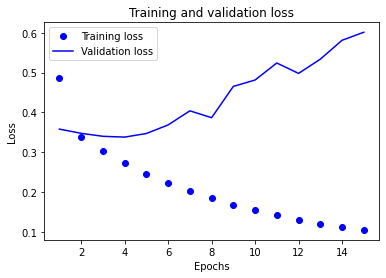

In [210]:
#loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

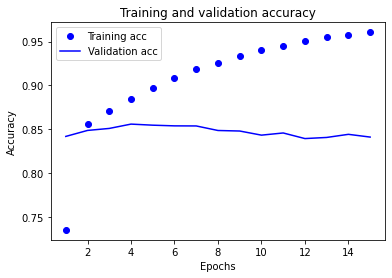

In [211]:
# ac
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## COMMENT

- 모델 1 정의    

```

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param    
=================================================================
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         


Total params: 163,761
Trainable params: 163,761
Non-trainable params: 0

```

- 모델 1 결과 80%

```
1537/1537 - 1s - loss: 1.0312 - accuracy: 0.8016
[1.0311740636825562, 0.8016355633735657]
```

- 모델2  정의    

```

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param    

embedding_5 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       

Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
````
    
- 모델2 결과  82.5%   

```
1537/1537 - 1s - loss: 0.4750 - accuracy: 0.8257
[0.4750464856624603, 0.8257012963294983]

```

- 모델 3 정의

```
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_6 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
=================================================================
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
```

- 모델3 결과 83.5%
```
1537/1537 - 2s - loss: 0.6117 - accuracy: 0.8357
[0.6117311120033264, 0.8357304334640503]
```

- word2vec 임베딩 적용 85%

```
1537/1537 - 3s - loss: 0.6086 - accuracy: 0.8507
[0.6085535883903503, 0.8506824970245361]
```

- conv 일때 80%, keras embedding layer 사용 82.5%, LSTM 사용 83%로 개선되 었고
- 한국어 word2vec 를 적용하고 85%까지 개선되었다.
- 한국어 임베딩이 확실해 유사 단어(스토리, 장르)를 검색했을때 좀 더 잘 찾는거 같았다.
- 스토리 유사단어 모델3(lstm적용) 임베딩 분석과 한국어 임베딩 분석결과 
![](./imgs/01-c.png)